# Feature Sets

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

### create helper pre process methods

In [2]:
def preprocess_features(california_housing_dataframe):
    """
    Prepare input features from California housing data
    
    Args:
        california_housing_dataframe: Pandas DataFrame, containing data from CA housing data set
    Returns:
        A Pandas DataFrame containing features used for the model
    """
    
    selected_features = california_housing_dataframe[[
        'latitude',
        'longitude',
        'housing_median_age',
        'total_rooms',
        'total_bedrooms',
        'population',
        'households',
        'median_income']]
    preprocessed_features = selected_features.copy()
    
    #create synthetic feature 'rooms_per_person'
    preprocessed_features['rooms_per_person'] = (
        california_housing_dataframe['total_rooms'] / 
        california_housing_dataframe['population'])
    return preprocessed_features

In [3]:
def preprocess_targets(california_housing_dataframe):
    """
    Prepare target features (i.e., labels) from CA housing data set
    
    Args:
        california_housing_dataframe: Pandas DataFrame, containing data from CA housing data set
    Returns:
        A Pandas DataFrame containing features used for the model
    """
    output_targets = pd.DataFrame()
    # scale target
    output_targets['median_house_value'] = (
        california_housing_dataframe['median_house_value'] / 1000.0)
    return output_targets

### split data into training/validation & remember to shuffle

In [4]:
shuffled_df = california_housing_dataframe.sample(frac=1).reset_index(drop=True)

In [5]:
# choose first 12,000 for training
training_examples = preprocess_features(shuffled_df).head(12000)
training_targets = preprocess_targets(shuffled_df).head(12000)

In [6]:
# choose last 5000 for validation
validation_examples = preprocess_features(shuffled_df).tail(5000)
validation_targets = preprocess_targets(shuffled_df).tail(5000)

In [7]:
# double-check 
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.5,28.7,2624.0,535.1,1416.3,497.5,3.9,2.0
std,2.1,2.0,12.6,2137.7,413.8,1087.7,377.9,1.9,1.3
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1454.8,294.0,783.0,280.0,2.6,1.5
50%,34.2,-118.5,29.0,2121.0,430.5,1162.0,407.0,3.5,1.9
75%,37.7,-118.0,37.0,3136.0,646.0,1711.0,603.0,4.8,2.3
max,42.0,-114.3,52.0,32054.0,5290.0,15507.0,5050.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.4,2690.8,549.8,1461.5,510.1,3.9,2.0
std,2.1,2.0,12.7,2277.6,439.3,1280.4,399.8,1.8,0.9
min,32.5,-124.3,2.0,12.0,4.0,9.0,5.0,0.5,0.0
25%,33.9,-121.8,18.0,1474.0,303.0,804.0,286.0,2.6,1.5
50%,34.3,-118.5,28.0,2149.0,441.0,1179.5,414.0,3.6,1.9
75%,37.7,-118.0,37.0,3186.2,658.0,1752.0,611.0,4.7,2.3
max,41.9,-114.6,52.0,37937.0,6445.0,35682.0,6082.0,15.0,18.3


Training targets summary:


,median_house_value
count,12000.0
mean,207.3
std,116.8
min,15.0
25%,118.8
50%,180.4
75%,265.1
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,207.4
std,114.1
min,17.5
25%,122.7
50%,180.4
75%,264.6
max,500.0


## Task 1: Develop a Good Feature Set

In [8]:
correlation_df = training_examples.copy()
correlation_df['target'] = training_targets['median_house_value']

correlation_df.corr()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.1,-0.1
longitude,-0.9,1.0,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.1,-0.0
housing_median_age,0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.1
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.1,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.2,0.7
rooms_per_person,0.1,-0.1,-0.1,0.1,0.0,-0.1,-0.0,0.2,1.0,0.2
target,-0.1,-0.0,0.1,0.1,0.1,-0.0,0.1,0.7,0.2,1.0


In [9]:
def construct_feature_column(input_features):
    """
    Construct the TensorFlow feature column
    
    Args:
        input_features: The names of the numerical input features to use
    Returns:
        A set of feature columns
    """
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [10]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """
    Train a linear regresssion model of one feature
    
    Args:
        features: Pandas DataFrame of features
        targets: Pandas DataFrame of targets
        batch_size: Size of batches
        shuffle: True or False.  Whether to shuffle data
        num_epochs: Number of epochs to repeat over data, None = indefinitely
    Returns:
        Tuple of (features,labels) for next data batch
    """
    
    # convert pandas data into dict of np arrays
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    # construct dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # shuffle if needed
    if shuffle:
        ds.shuffle(10000)
    
    # return next batch
    features, labels = ds.make_one_shot_iterator().get_next()
    return features,labels

In [11]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """
    Trains a linear regression model.
    
    Prints training progression info.  Also plots training and vlidation loss over time
    
    Args:
        learning_rate: A 'float', the learning rate
        steps: A non-zero 'int', number of training steps.  
            A training step is one forward and backward pass through single batch.
        batch_size: A non-zero 'int', size of batch
        training_examples: A pandas 'DataFrame', containing one or more columns from CA housing data
            to use as input feature(s) for training
        training_targets: A pandas 'DataFrame', containing one column from CA housing data to use as target for training
        validation_examples: A pandas 'DataFrame', containing one or more columns from CA housing data
            to use as input feature(s) for validation
        validation_targets: A pandas 'DataFrame', containing one column from CA housing data to use as target for validation
    """
    
    periods = 10
    steps_per_period= steps / periods
    
    # create linear regressor
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate,)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        construct_feature_column(training_examples), 
        optimizer=my_optimizer)
    
    # create input functions
    training_input_fn = lambda: my_input_fn(
        training_examples, training_targets['median_house_value'], batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(
        training_examples, training_targets['median_house_value'], num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(
        validation_examples, validation_targets['median_house_value'], num_epochs=1, shuffle=False)
    
    # train model, use loop to assess loss metrics
    print("Training model...")
    print("RMSE (training):")
    training_rmse = []
    validation_rmse = []
    for period in range(0, periods):
        
        # train the model, picking up from previous state
        linear_regressor.train(training_input_fn, steps=steps_per_period)
        
        # compute predictions
        training_preds = linear_regressor.predict(predict_training_input_fn)
        training_preds = np.array([item['predictions'][0] for item in training_preds])
        
        validation_preds = linear_regressor.predict(predict_validation_input_fn)
        validation_preds = np.array([item['predictions'][0] for item in validation_preds])
        
        # compute training and validation loss
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_targets, training_preds))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_targets, validation_preds))
        
        # occasional printout
        print("    period %02d: %0.2f" % (period, training_root_mean_squared_error))
        
        # add loss metrics from this period to list
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")
    
    # output graph of loss metrics over periods
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("RMSE vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return linear_regressor

Training model...
RMSE (training):
    period 00: 120.96
    period 01: 115.62
    period 02: 113.37
    period 03: 111.19
    period 04: 109.09
    period 05: 107.06
    period 06: 105.12
    period 07: 103.26
    period 08: 101.49
    period 09: 99.81
Model training finished.


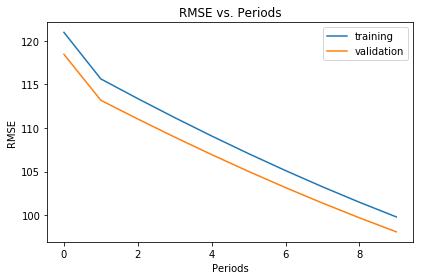

In [12]:
minimal_features = ['median_income', 'latitude', 'rooms_per_person']

assert minimal_features, "You must select at least one feature"

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

train_model(
    learning_rate=.01, 
    steps=1000, 
    batch_size=32, 
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)
            

## Task 2: Make Better use of Latitude

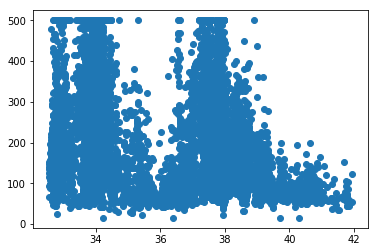

In [13]:
plt.scatter(training_examples['latitude'], training_targets['median_house_value'])

In [15]:
def build_synth_col(source_df):
    
    selected_examples = pd.DataFrame()
    selected_examples['median_income'] = source_df['median_income']
    selected_examples[new_feat] = source_df['latitude'] - 38.0
    return selected_examples

In [34]:
def call_train_model(train_samples, validation_samples):
    train_model(
        learning_rate=.01, 
        steps=500, 
        batch_size=5, 
        training_examples=train_samples,
        training_targets=training_targets,
        validation_examples=validation_samples,
        validation_targets=validation_targets)

In [16]:
selected_train_examples = build_synth_col(training_examples)
selected_validation_examples = build_synth_col(validation_examples)

Training model...
RMSE (training):
    period 00: 214.68
    period 01: 192.00
    period 02: 170.05
    period 03: 149.17
    period 04: 129.84
    period 05: 112.83
    period 06: 99.28
    period 07: 90.75
    period 08: 87.22
    period 09: 85.78
Model training finished.


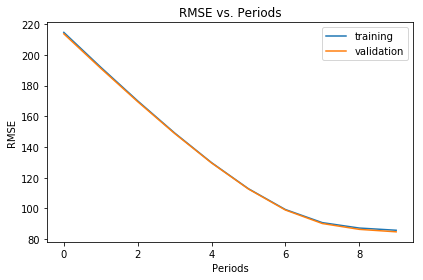

In [29]:
call_train_model(selected_train_examples, selected_validation_examples)

In [31]:
def bin_lats(source_df):
    
    lat_ranges = zip(range(32,44), range(33,45))
    df = pd.DataFrame()
    df['median_income'] = source_df['median_income']
    for r in lat_ranges:
        df['lat_%d_to_%d' % r] = source_df['latitude'].apply(
            lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
    return df

In [35]:
binned_training_examples = bin_lats(training_examples)
display.display(binned_training_examples.describe())
binned_validation_examples = bin_lats(validation_examples)
display.display(binned_validation_examples.describe())

,median_income,lat_32_to_33,lat_33_to_34,lat_34_to_35,lat_35_to_36,lat_36_to_37,lat_37_to_38,lat_38_to_39,lat_39_to_40,lat_40_to_41,lat_41_to_42,lat_42_to_43,lat_43_to_44
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,3.9,0.1,0.2,0.2,0.0,0.1,0.2,0.1,0.0,0.0,0.0,0.0,0.0
std,1.9,0.2,0.4,0.4,0.2,0.2,0.4,0.3,0.2,0.1,0.1,0.0,0.0
min,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,4.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,15.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


,median_income,lat_32_to_33,lat_33_to_34,lat_34_to_35,lat_35_to_36,lat_36_to_37,lat_37_to_38,lat_38_to_39,lat_39_to_40,lat_40_to_41,lat_41_to_42,lat_42_to_43,lat_43_to_44
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,3.9,0.1,0.2,0.3,0.0,0.1,0.2,0.1,0.0,0.0,0.0,0.0,0.0
std,1.8,0.2,0.4,0.4,0.1,0.2,0.4,0.3,0.2,0.1,0.1,0.0,0.0
min,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,3.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,4.7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,15.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


Training model...
RMSE (training):
    period 00: 227.60
    period 01: 217.38
    period 02: 207.26
    period 03: 197.23
    period 04: 187.31
    period 05: 177.54
    period 06: 167.92
    period 07: 158.49
    period 08: 149.29
    period 09: 140.36
Model training finished.


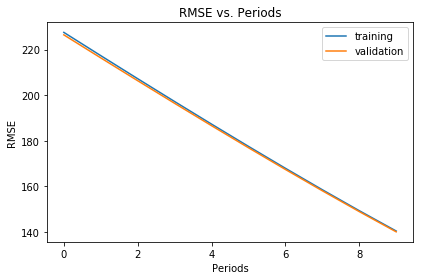

In [36]:
call_train_model(binned_training_examples, binned_validation_examples)